In [8]:
import warnings;
warnings.filterwarnings('ignore');

In [9]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from theano import tensor as T
import matplotlib.pyplot as plt

In [10]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
quest_before.head()

,Participant nr,NR,Created,Modified,Consent,Q1,Q2,Q3,Q4,Q5,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Total Score extended,Total Score original,Elapsed time
Participant,,,,,,,,,,,,,,,,,,,,,
1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,2,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,3,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


## __Free viewing__

<AxesSubplot: >

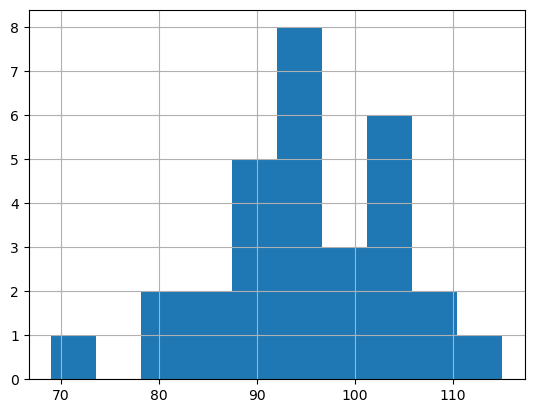

In [11]:
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist()

### __Fixations__

In [6]:
AGGREGATED_PATH = "output/aggregated_features/"

def get_fix_free_features(sub_nr, dset="test"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        fix_features = pickle.load(f)[0]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(fix_features))
    return fix_features, labels

In [7]:
free_fix_train_features = []
free_fix_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr)
        for feature in features:
            free_fix_train_features.append(feature)
        for label in labels:
            free_fix_train_labels.append(label)

free_fix_features_train = np.array(free_fix_train_features)
free_fix_features_train = (free_fix_features_train - free_fix_features_train.min(axis=0))/(free_fix_features_train.max(axis=0)-free_fix_features_train.min(axis=0))
free_fix_labels = np.array(free_fix_train_labels)

In [77]:
with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    y = pm.Data("y", free_fix_train_labels)
    a = pm.Normal("a", mu= 6, sigma=20)
    b = pm.Normal("b", mu=6, sigma=20, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 3)
    λ = pm.math.exp(a + T.dot(X, b.T))
    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=y, shape = X.eval().shape[0])

    free_fix_empathy_trace = pm.sample(4000, tune=5000)


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 734 seconds.


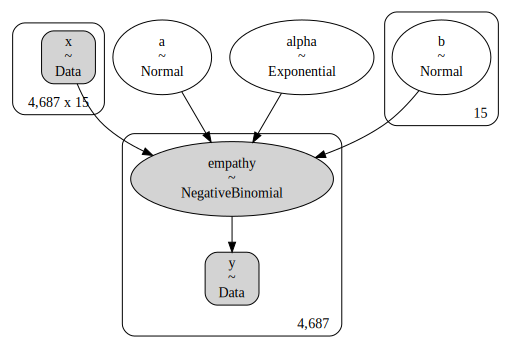

In [94]:
pm.model_graph.model_to_graphviz(free_fix_empathy)

In [ ]:
with open("models/free_fix_empathy_mean_6_20_6_20_3", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

__Model checking__

In [34]:
with open("models/free_fix_empathy_mean_6_10_6_10_2", 'rb') as buff:
    model_data = pickle.load(buff)
    free_fix_empathy = model_data["model"]
    free_fix_empathy_trace = model_data["trace"]

In [35]:
pois_loo = az.loo(free_fix_empathy_trace, free_fix_empathy)
pois_loo

Computed from 16000 by 4687 log-likelihood matrix

         Estimate       SE
elpd_loo -16916.03    27.99
p_loo        7.24        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4686  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [36]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.54,0.05,4.45,4.63,0.00,0.00,12048.42,11428.27,1.0
b[0],-0.11,0.31,-0.69,0.45,0.00,0.00,14677.67,10683.27,1.0
b[1],-0.03,0.07,-0.16,0.10,0.00,0.00,12137.07,10987.52,1.0
b[2],0.01,0.18,-0.32,0.34,0.00,0.00,12473.42,10881.69,1.0
b[3],0.18,0.27,-0.33,0.67,0.00,0.00,14620.87,10645.72,1.0
b[4],-0.05,0.05,-0.14,0.04,0.00,0.00,14400.30,11928.08,1.0
b[5],-0.01,0.14,-0.26,0.24,0.00,0.00,12477.27,10474.87,1.0
b[6],0.04,0.09,-0.14,0.21,0.00,0.00,11230.99,11859.64,1.0
b[7],0.03,0.01,0.01,0.06,0.00,0.00,20424.56,11483.97,1.0
b[8],-0.01,0.07,-0.15,0.12,0.00,0.00,9748.10,10304.45,1.0


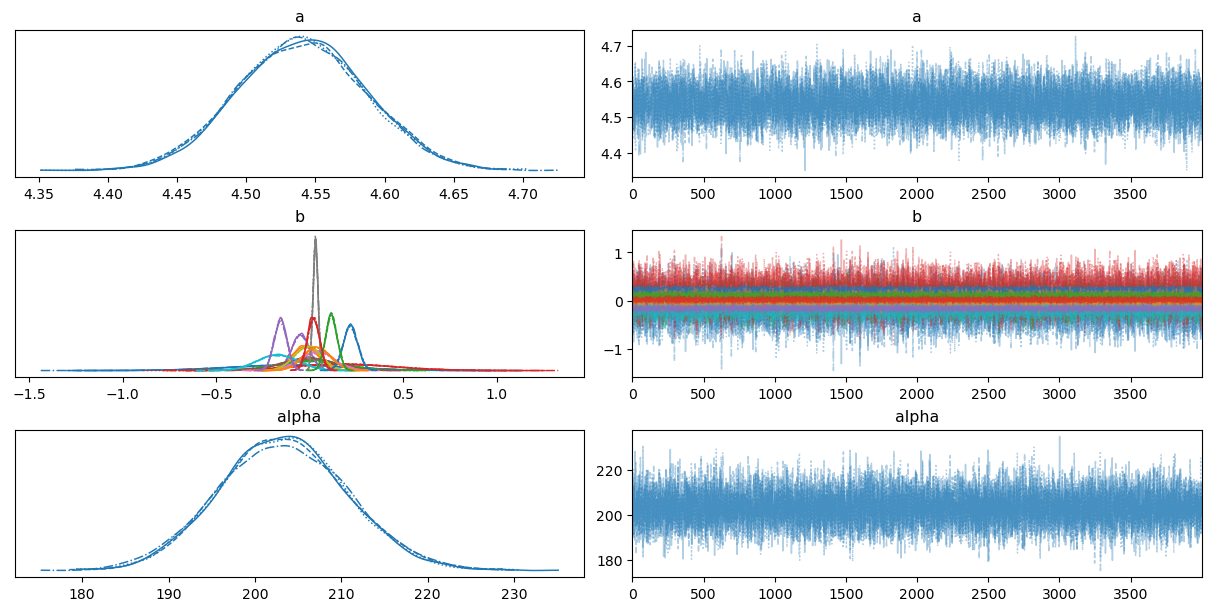

In [37]:
az.plot_trace(free_fix_empathy_trace);

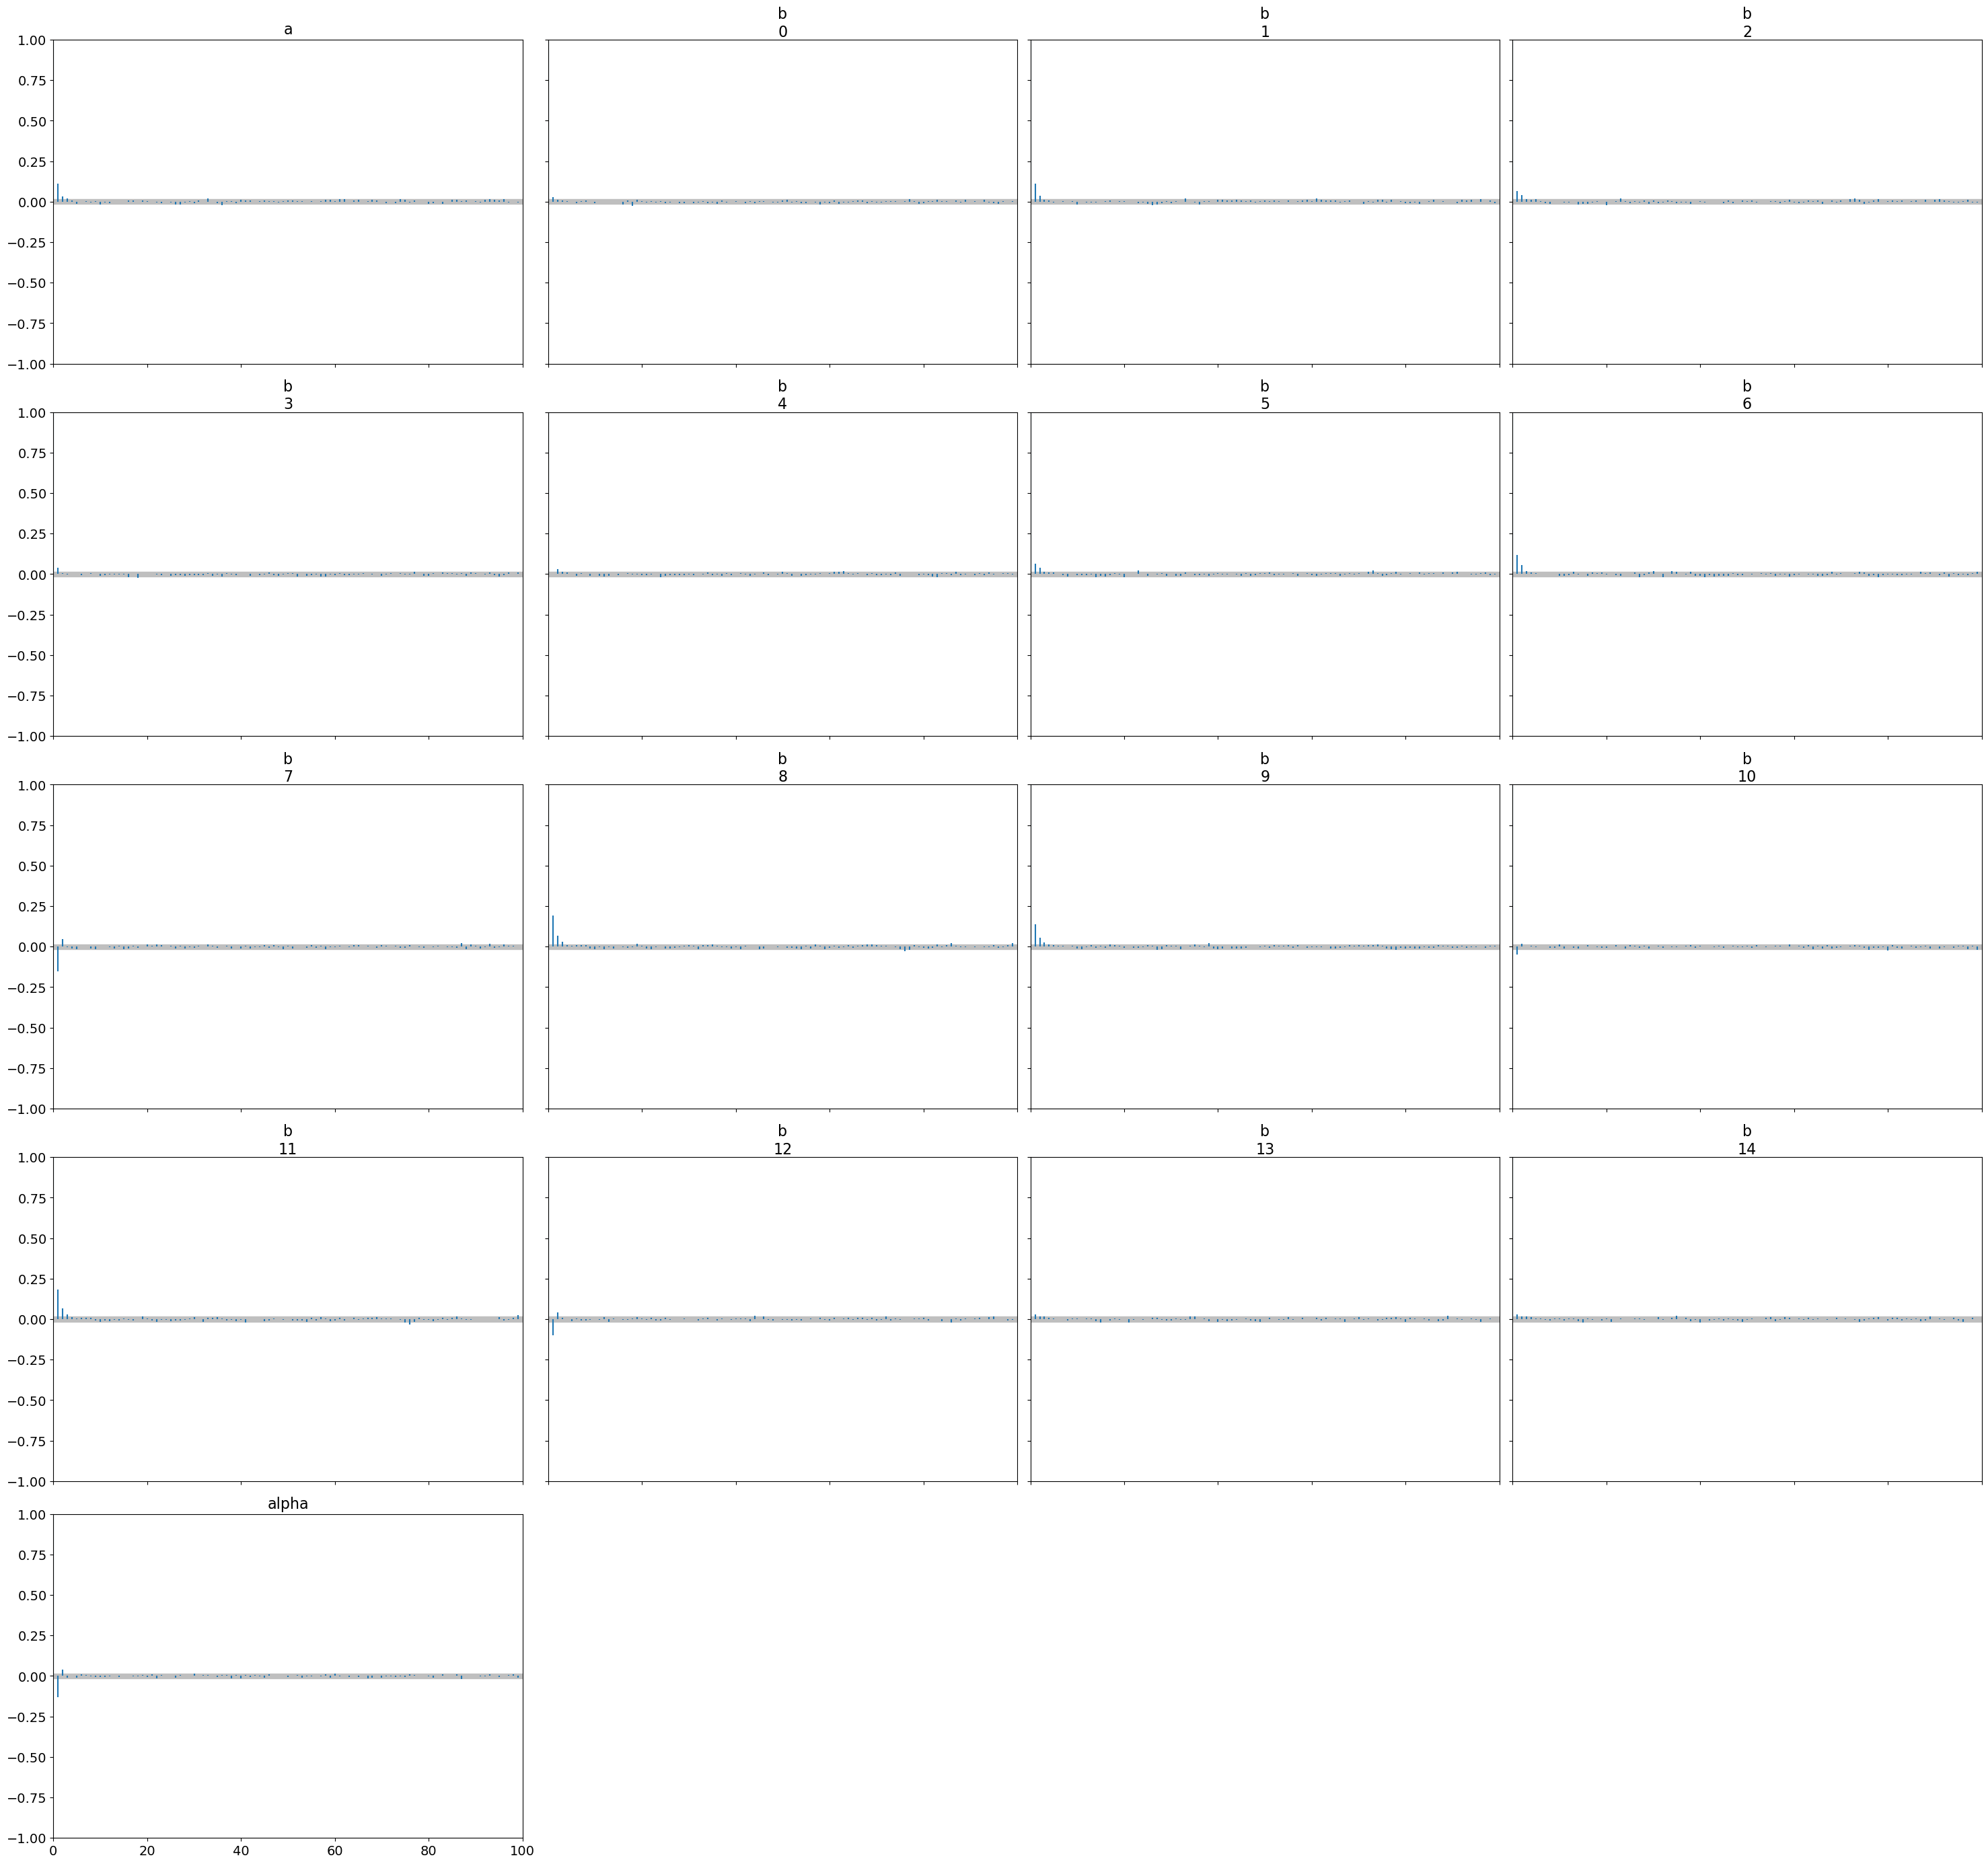

In [38]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

__Posterior predictive check__

In [39]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [40]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [41]:
mean_squared_error(free_fix_train_labels, fix_free_sampled_labels, squared= False)

7.9037955653867895

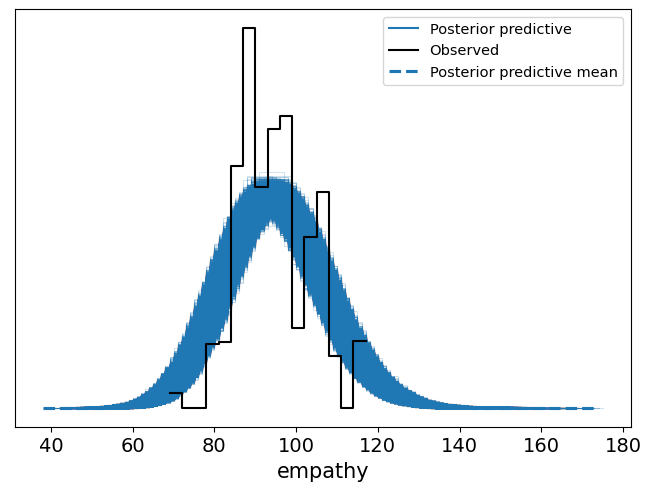

In [42]:
az.plot_ppc(fix_free_ppc_data);

__Test predictions__

In [43]:
free_fix_test_features = []
free_fix_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr, dset="test")
        for feature in features:
            free_fix_test_features.append(feature)
        for label in labels:
            free_fix_test_labels.append(label)

free_fix_test_features = np.array(free_fix_test_features)
free_fix_test_features = (free_fix_test_features - free_fix_test_features.min(axis=0))/(free_fix_test_features.max(axis=0)-free_fix_test_features.min(axis=0))
free_fix_test_labels = np.array(free_fix_test_labels)

In [46]:
with free_fix_empathy:
    pm.set_data({"x": free_fix_test_features})
    fix_free_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [47]:
fix_free_predictions = fix_free_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_fix_test_labels, fix_free_predictions, squared= False)

7.902349001644026

### __Saccades__

In [12]:
def get_sac_free_features(sub_nr, dset="train"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        sac_features = pickle.load(f)[1]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(sac_features))
    return sac_features, labels

In [13]:
free_sac_train_features = []
free_sac_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr)
        for feature in features:
            free_sac_train_features.append(feature)
        for label in labels:
            free_sac_train_labels.append(label)

free_sac_train_features = np.array(free_sac_train_features)
free_sac_train_features = (free_sac_train_features - free_sac_train_features.min(axis=0))/(free_sac_train_features.max(axis=0)-free_sac_train_features.min(axis=0))
free_sac_train_labels = np.array(free_sac_train_labels)

In [16]:
with pm.Model() as free_sac_empathy:
    X = pm.Data("x", free_sac_train_features)
    y = pm.Data("y", free_sac_train_labels)

    a = pm.Normal("intercept", mu= 0, sigma= 10)
    b = pm.Normal("beta", mu=0, sigma=10, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))

    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=y, shape = X.eval().shape[0])

    free_sac_empathy_trace = pm.sample(4000, tune=5000)


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 1107 seconds.


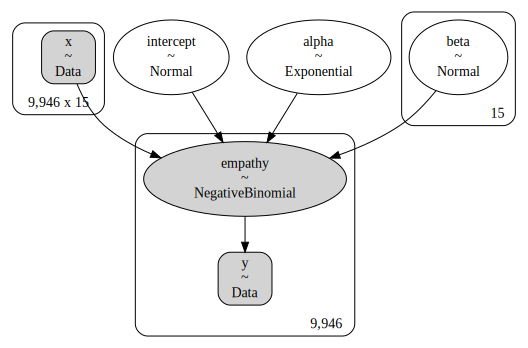

In [17]:
pm.model_graph.model_to_graphviz(free_sac_empathy)

In [20]:
with open("models/free_sac_empathy_0_10_0_10_05.pickle", 'wb') as buff:
    pickle.dump({'model': free_sac_empathy, 'trace': free_sac_empathy_trace}, buff)

__Model checking__

In [21]:
with open("models/free_sac_empathy_0_10_0_10_05.pickle", 'rb') as buff:
    model_data = pickle.load(buff)
    free_sac_empathy = model_data["model"]
    free_sac_empathy_trace = model_data["trace"]

In [22]:
az.summary(free_sac_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.56,0.02,4.53,4.59,0.00,0.00,9124.94,10735.72,1.0
beta[0],0.01,0.04,-0.05,0.08,0.00,0.00,9769.49,10273.42,1.0
beta[1],-0.02,0.02,-0.06,0.02,0.00,0.00,10050.59,10754.14,1.0
beta[2],-0.10,0.07,-0.24,0.04,0.00,0.00,9193.90,10130.96,1.0
beta[3],-0.05,0.06,-0.15,0.06,0.00,0.00,9414.73,10957.79,1.0
beta[4],-0.02,0.05,-0.12,0.08,0.00,0.00,10848.09,11247.61,1.0
beta[5],0.11,0.06,0.00,0.21,0.00,0.00,9880.55,10625.49,1.0
beta[6],-0.00,0.03,-0.05,0.04,0.00,0.00,8721.16,10229.17,1.0
beta[7],-0.00,0.00,-0.01,0.01,0.00,0.00,14520.60,11577.60,1.0
beta[8],0.01,0.02,-0.03,0.05,0.00,0.00,8476.60,10215.12,1.0


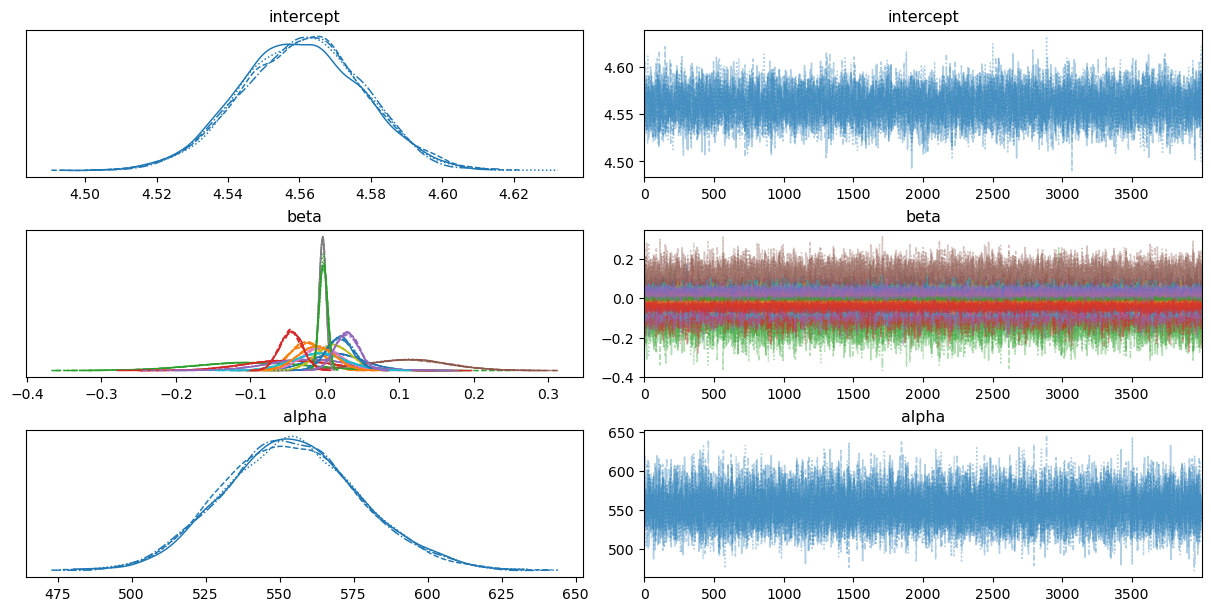

In [23]:
trace = az.plot_trace(free_sac_empathy_trace)

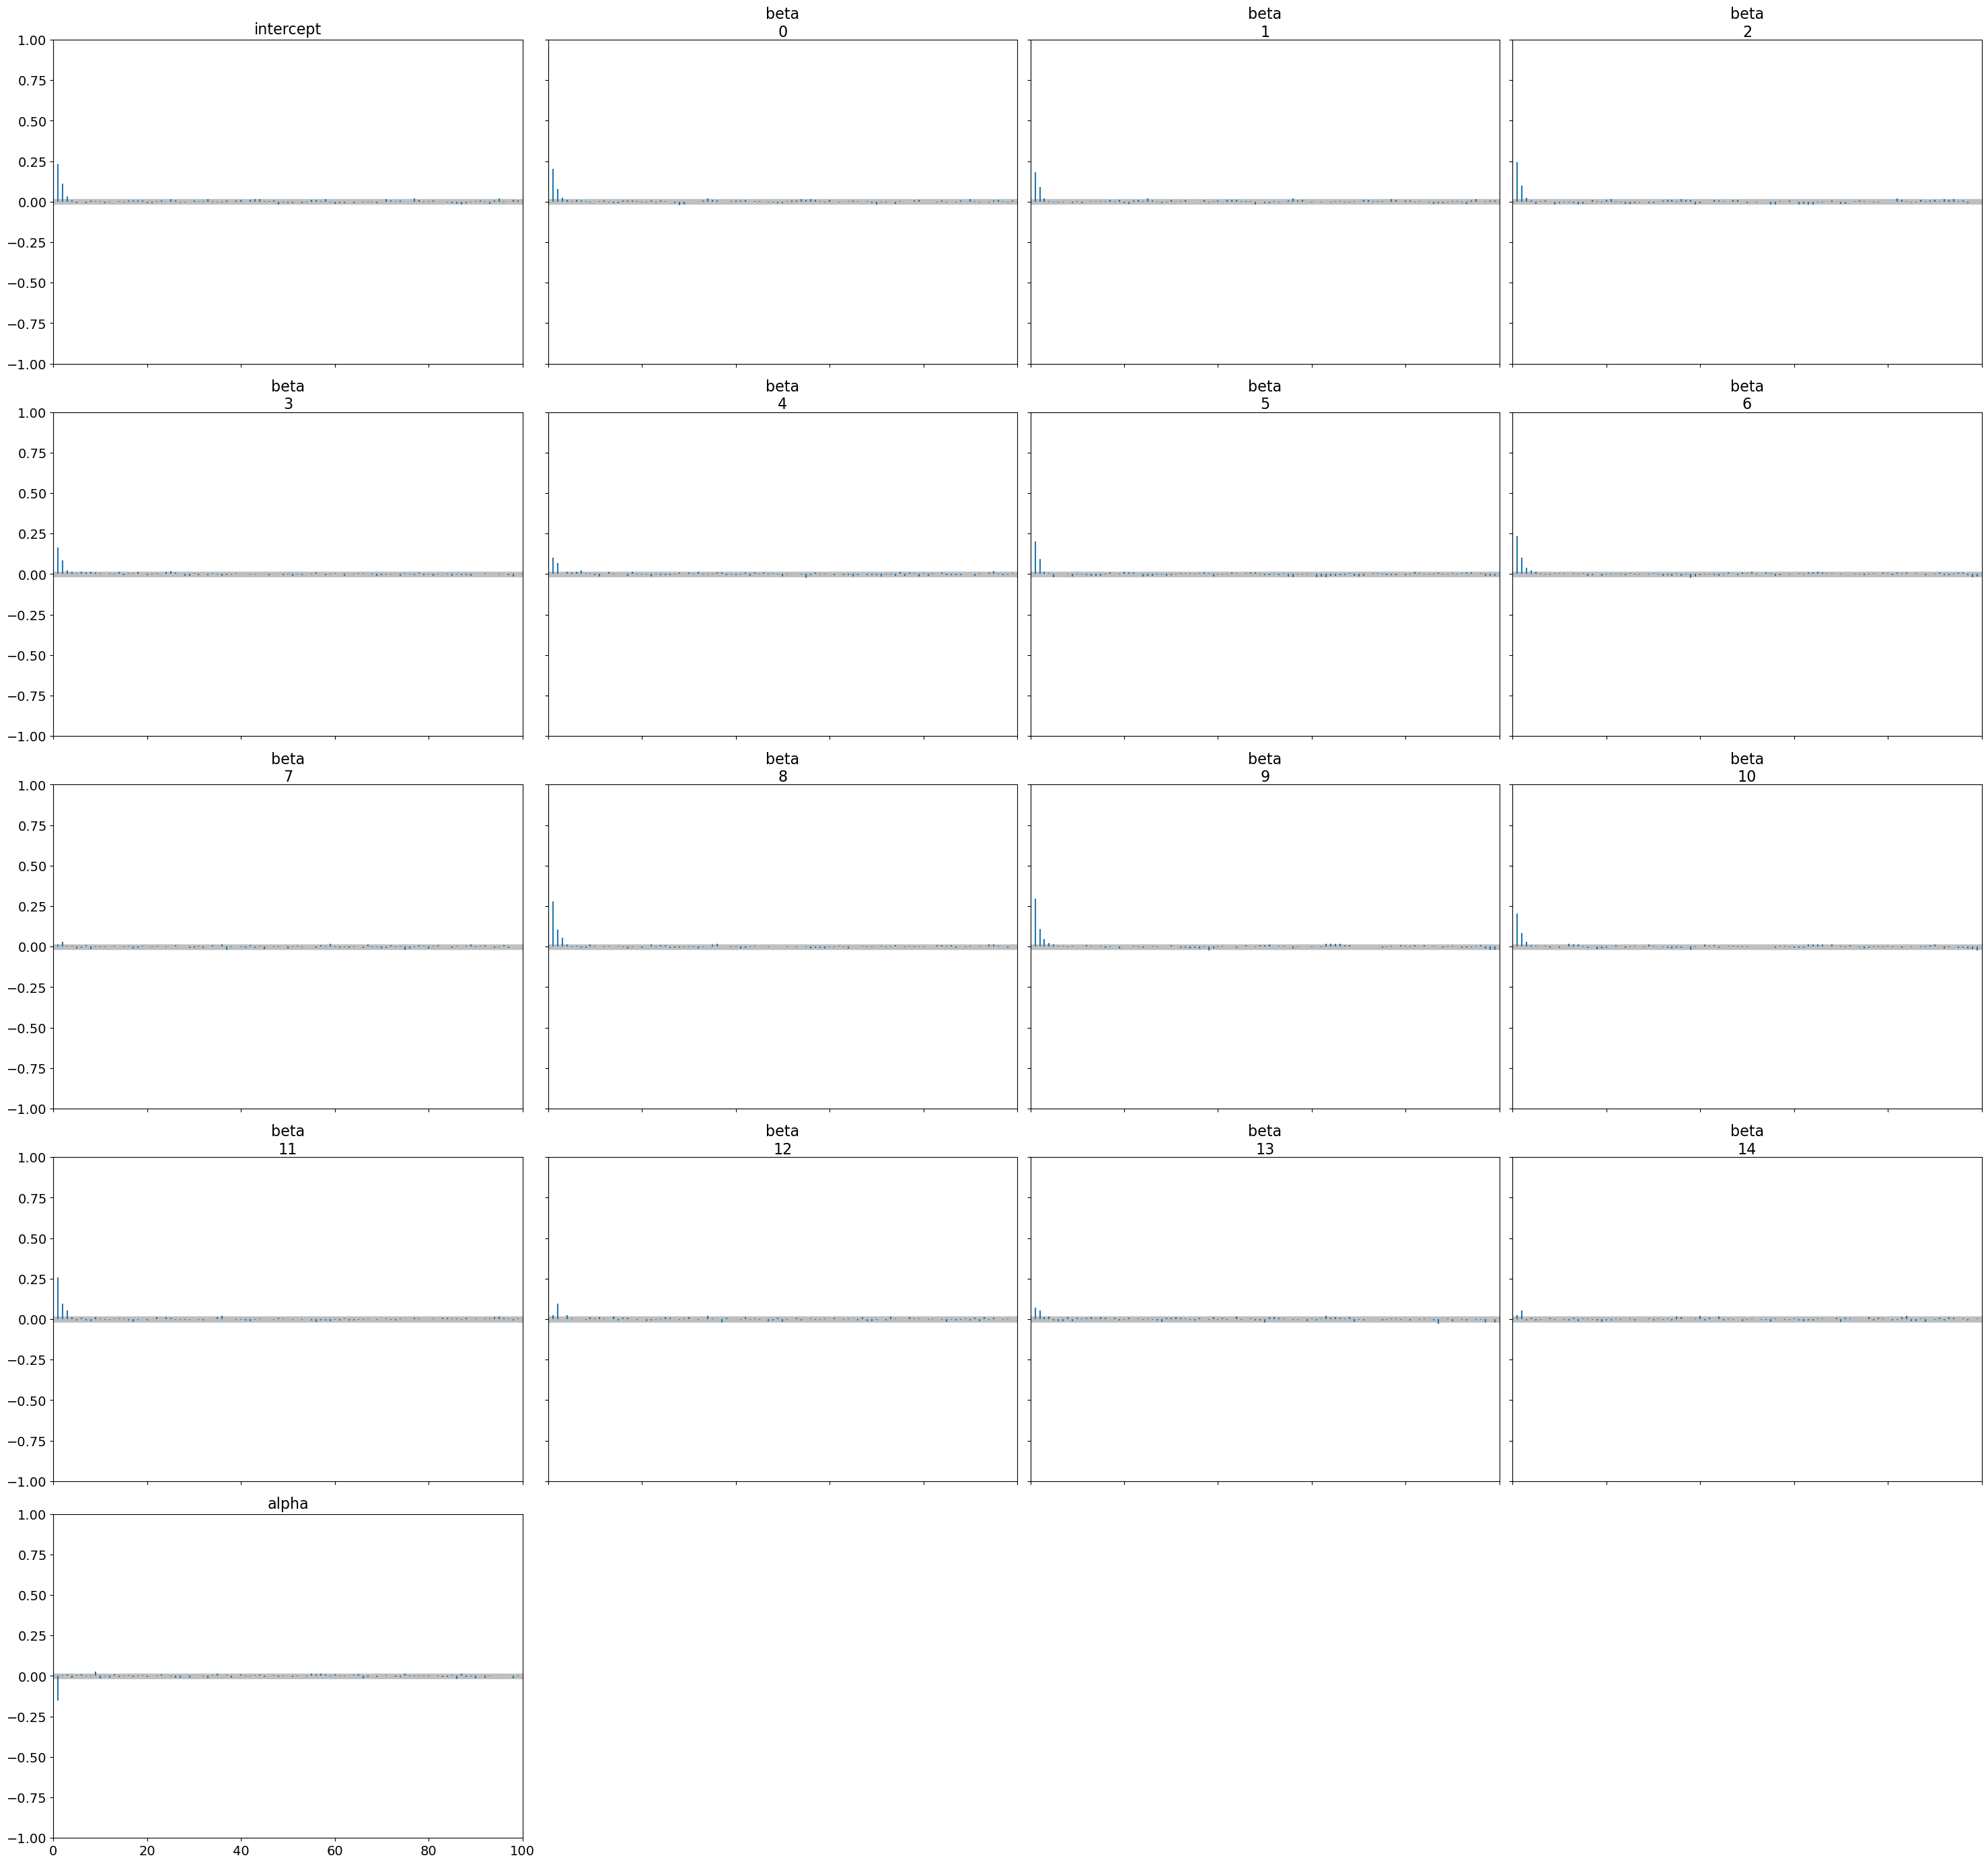

In [24]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

In [25]:
with free_sac_empathy:
    sac_free_ppc = pm.sample_posterior_predictive(free_sac_empathy_trace)
    sac_free_ppc_data = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_ppc) 
    sac_free_sampled_labels = sac_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [26]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_sac_train_labels, sac_free_sampled_labels, squared= False)

8.212454339357366

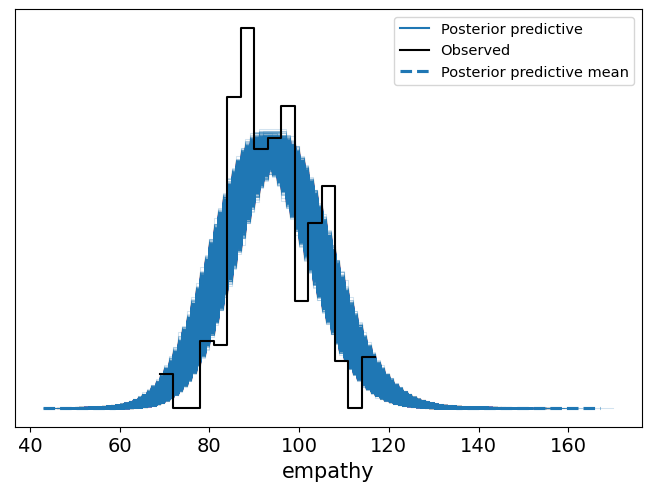

In [27]:
az.plot_ppc(sac_free_ppc_data);

__Test predictions__

In [28]:
free_sac_test_features = []
free_sac_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr, dset="test")
        for feature in features:
            free_sac_test_features.append(feature)
        for label in labels:
            free_sac_test_labels.append(label)

free_sac_test_features = np.array(free_sac_test_features)
free_sac_test_features = (free_sac_test_features - free_sac_test_features.min(axis=0))/(free_sac_test_features.max(axis=0)-free_sac_test_features.min(axis=0))
free_sac_test_labels = np.array(free_sac_test_labels)

In [29]:
with free_sac_empathy:
    pm.set_data({"x": free_sac_test_features})
    free_sac_predictions = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [30]:
sac_free_predictions = free_sac_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_sac_test_labels, sac_free_predictions, squared= False)

8.308356277772287

__Combined prediction__

In [31]:
free_fix_stimuli = []
free_sac_stimuli = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        with open(f"{AGGREGATED_PATH}/test/event_features_{sub_nr:02}_agg.pickle", "rb") as f:
            _, _, fix_stimuli, sac_stimuli = pickle.load(f)
            for stim in fix_stimuli:
                free_fix_stimuli.append((stim[0], sub_nr))
            for stim in sac_stimuli:
                free_sac_stimuli.append((stim[0], sub_nr))


In [48]:
from itertools import groupby
from operator import itemgetter
from collections import Counter

fix_predicted_empathy = {}

fix_stimulus_groups = [list(group)for key, group in groupby(list(zip(fix_free_predictions,free_fix_stimuli)), itemgetter(1))]
for fix_stimulus in fix_stimulus_groups:
    fix_predicted_empathy[(fix_stimulus[0][1][0], fix_stimulus[0][1][1])] = np.mean([value[0] for value in fix_stimulus])

sac_predicted_empathy = {}
sac_stimulus_groups = [list(group)for key, group in groupby(list(zip(sac_free_predictions,free_sac_stimuli)), itemgetter(1))]
for sac_stimulus in sac_stimulus_groups:
    sac_predicted_empathy[(sac_stimulus[0][1][0], sac_stimulus[0][1][1])] = np.mean([value[0] for value in sac_stimulus])

predicted_empathy = dict(pd.DataFrame([fix_predicted_empathy, sac_predicted_empathy]).mean())
real_empathy_values = [free_viewing_empathy[k[1]] for k in predicted_empathy.keys()]
predicted_empathy_values = list(predicted_empathy.values())
mean_squared_error(predicted_empathy_values, real_empathy_values, squared=False)

8.859813665348636

In [49]:
np.unique(predicted_empathy.values())

array([dict_values([93.7888705357143, 93.42192306189904, 95.35949194560604, 93.67902256167102, 95.32444375, 94.83286279184003, 94.02373486086891, 94.51823269704433, 93.83931446292095, 93.0276649287948, 93.18127429618363, 93.5064453125, 94.16782292400922, 95.76537637061404, 94.51115463935574, 94.5211953125, 93.96737934819319, 92.56403125, 92.9737741446199, 94.41738151041667, 94.8889527529762, 93.83634375, 94.02621445955825, 93.52771235079484, 93.01315446428572, 92.41806862745099, 92.73319014120369, 93.77163636363636, 93.13093949564586, 95.14004166666666, 94.85913135626224, 95.89463199344758, 95.06536373782077, 95.86792450335398, 91.99537786458333, 95.23072135416666, 94.63997927874472, 94.47203124999999, 93.111145, 93.27163979855371, 93.3322701097641, 92.33421459009739, 92.71311772321428, 92.63965776134671, 92.94148431122449, 94.16082037037035, 95.3640445324006, 93.59005592105262, 93.78761036227652, 92.01536351415695, 96.81059375000001, 94.34245014880952, 94.6299001572327, 94.22412326388

In [50]:
np.unique(real_empathy_values)

array([ 69,  79,  82,  86,  87,  88,  89,  92,  93,  94,  95,  96,  97,
       100, 102, 104, 105, 106, 109, 115])

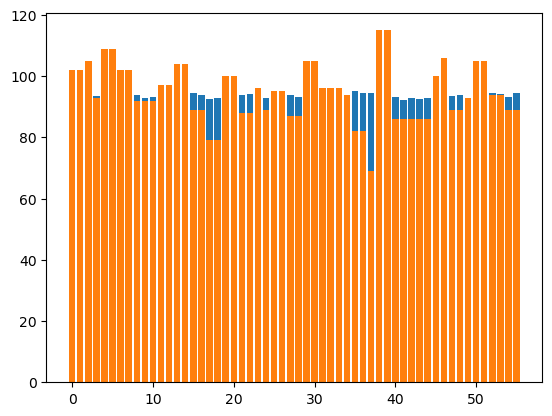

In [51]:
plt.bar(range(len(predicted_empathy_values)), predicted_empathy_values)
plt.bar(range(len(real_empathy_values)), real_empathy_values)
plt.show()